In [1]:
import librosa
import IPython.display as display
import torch
from speechbrain.lobes.augment import EnvCorrupt as EnvCorrupt
from speechbrain.processing.speech_augmentation import AddNoise
from speechbrain.processing.speech_augmentation import SpeedPerturb
from speechbrain.processing.speech_augmentation import DropChunk
from datasets import load_dataset
from datasets import load_metric
import numpy as np
import torch
import soundfile as sf

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, HubertForCTC, AutoModelForCTC, AutoTokenizer

In [2]:
dset = load_dataset("timit_asr", split="test").shuffle().select(np.arange(0, 200))
dset = dset.remove_columns(['phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'])
print(dset)
wer_metric = load_metric("wer")

Reusing dataset timit_asr (/home-nfs/goutham/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad)


Dataset({
    features: ['file', 'audio', 'text'],
    num_rows: 200
})


In [3]:
model_name = "elgeish/wav2vec2-base-timit-asr"
w2v_processor = Wav2Vec2Processor.from_pretrained(model_name)
w2v_model = Wav2Vec2ForCTC.from_pretrained(model_name).cuda()
# w2v_model.eval()
char_translations = str.maketrans({"-": " ", ",": "", ".": "", "?": ""})

hubert_processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/distilhubert-timit")
hubert_model = AutoModelForCTC.from_pretrained("patrickvonplaten/distilhubert-timit").cuda()
hubert_tokenizer = AutoTokenizer.from_pretrained("patrickvonplaten/distilhubert-timit")
# hubert_model.eval()

/home-nfs/goutham/mc3/envs/my/lib/python3.10/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [4]:
def addnoise_noisy_decoding(batch, noise, model_type, noise_type):
    speech = batch["audio"]["array"]
    if noise_type == "white_noise":
        corrupter = AddNoise(mix_prob=noise)
        corr = corrupter(torch.Tensor([speech]), torch.ones(1))
    elif noise_type == "speed_perturb":
        perturbator = SpeedPerturb(orig_freq=16000,speeds=[noise])
        corr = perturbator(torch.Tensor([speech]))
    elif noise_type == "drop_chunk_length":            
        corrupter = DropChunk(drop_length_low=noise, drop_length_high=noise, drop_count_low=100, drop_count_high=100)
        corr = corrupter(torch.Tensor([speech]), torch.ones(1))
    elif noise_type == "drop_chunk_count":
        corrupter = DropChunk(drop_length_low=100, drop_length_high=100, drop_count_low=noise, drop_count_high=noise)
        corr = corrupter(torch.Tensor([speech]), torch.ones(1))
    
    batch["text"] = batch["text"].translate(char_translations)
    batch["text"] = " ".join(batch["text"].split())  # clean up whitespaces
    batch["text"] = batch["text"].lower()
        
    if model_type == "wav2vec2":
        input_values = w2v_processor(np.array(corr[0]), sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to("cuda")
        with torch.no_grad():
            logits = w2v_model(input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        pred_ids[pred_ids == -100] = w2v_processor.tokenizer.pad_token_id  # see fine-tuning script
        batch["pred_str"] = w2v_processor.batch_decode(pred_ids)[0]
        return batch
    elif model_type == "hubert":
        inputs = hubert_processor(np.array(corr[0]), sampling_rate=16000, return_tensors="pt").input_values.cuda()
        with torch.no_grad():
            logits = hubert_model(inputs).logits
        pred_ids = torch.argmax(logits, dim=-1)
        batch["pred_str"] = hubert_processor.batch_decode(pred_ids)[0]
        return batch
    else:
        return None

Parameter 'function'=<function addnoise_noisy_decoding at 0x7f877aa557e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Noise type: white_noise
Model_type: wav2vec2


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.0, Test WER: 0.263


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.1, Test WER: 0.304


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.2, Test WER: 0.340


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.30000000000000004, Test WER: 0.395


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.4, Test WER: 0.431


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.5, Test WER: 0.523


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.6000000000000001, Test WER: 0.563


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.7000000000000001, Test WER: 0.553


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.8, Test WER: 0.631


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0.9, Test WER: 0.638


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 1.0, Test WER: 0.710
Model_type: hubert


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.0, Test WER: 0.709


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.1, Test WER: 0.735


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.2, Test WER: 0.781


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.30000000000000004, Test WER: 0.820


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.4, Test WER: 0.862


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.5, Test WER: 0.899


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.6000000000000001, Test WER: 0.914


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.7000000000000001, Test WER: 0.947


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.8, Test WER: 1.011


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0.9, Test WER: 1.049


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 1.0, Test WER: 1.080
Noise type: speed_perturb
Model_type: wav2vec2


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 50, Test WER: 0.989


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 75, Test WER: 0.361


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 100, Test WER: 0.263


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 125, Test WER: 0.353


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 150, Test WER: 0.786


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 175, Test WER: 0.999


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 200, Test WER: 1.028


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 225, Test WER: 1.023
Model_type: hubert


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 50, Test WER: 1.014


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 75, Test WER: 0.863


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 100, Test WER: 0.709


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 125, Test WER: 0.866


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 150, Test WER: 1.039


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 175, Test WER: 1.082


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 200, Test WER: 1.101


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 225, Test WER: 1.131
Noise type: drop_chunk_length
Model_type: wav2vec2


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 0, Test WER: 0.263


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 100, Test WER: 0.316


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 200, Test WER: 0.406


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 300, Test WER: 0.604


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 400, Test WER: 0.814


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 500, Test WER: 0.915


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 600, Test WER: 0.967


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 700, Test WER: 0.979


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 800, Test WER: 0.978


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 900, Test WER: 0.991


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 1000, Test WER: 0.996
Model_type: hubert


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 0, Test WER: 0.709


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 100, Test WER: 0.900


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 200, Test WER: 0.992


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 300, Test WER: 0.994


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 400, Test WER: 0.998


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 500, Test WER: 0.997


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 600, Test WER: 0.997


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 700, Test WER: 0.997


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 800, Test WER: 0.995


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 900, Test WER: 0.997


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 1000, Test WER: 0.999
Noise type: drop_chunk_count
Model_type: wav2vec2


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 100, Test WER: 0.304


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 200, Test WER: 0.408


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 300, Test WER: 0.556


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 400, Test WER: 0.730


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 500, Test WER: 0.867


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 600, Test WER: 0.939


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 700, Test WER: 0.979


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 800, Test WER: 0.996


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 900, Test WER: 0.997


0ex [00:00, ?ex/s]

Model_type: wav2vec2, Noise: 1000, Test WER: 0.998
Model_type: hubert


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 100, Test WER: 0.910


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 200, Test WER: 0.997


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 300, Test WER: 0.988


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 400, Test WER: 0.988


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 500, Test WER: 0.995


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 600, Test WER: 0.998


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 700, Test WER: 0.998


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 800, Test WER: 0.998


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 900, Test WER: 1.000


0ex [00:00, ?ex/s]

Model_type: hubert, Noise: 1000, Test WER: 0.999


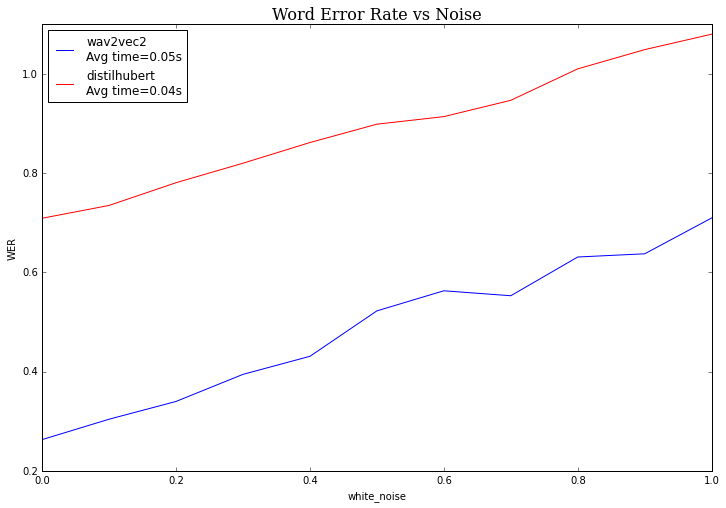

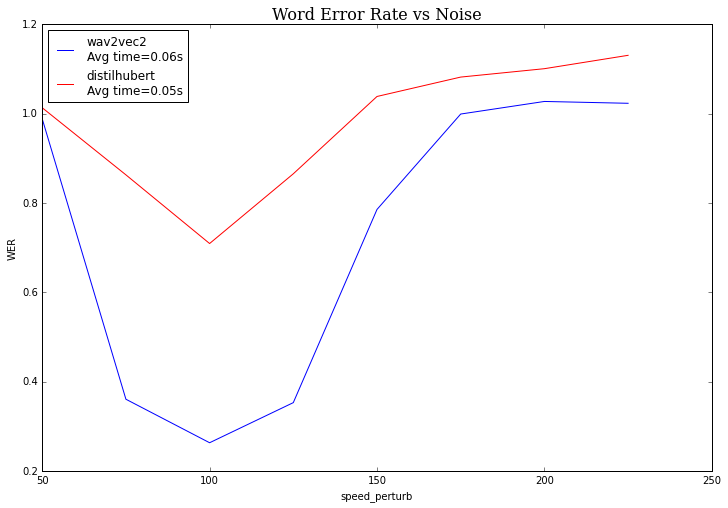

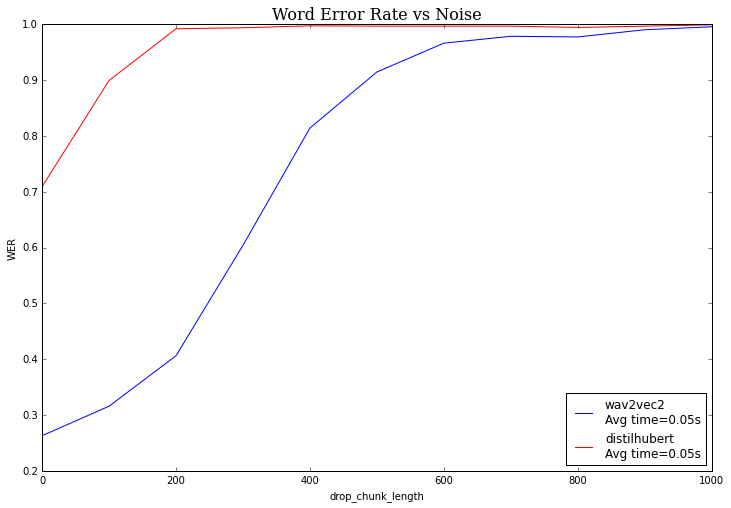

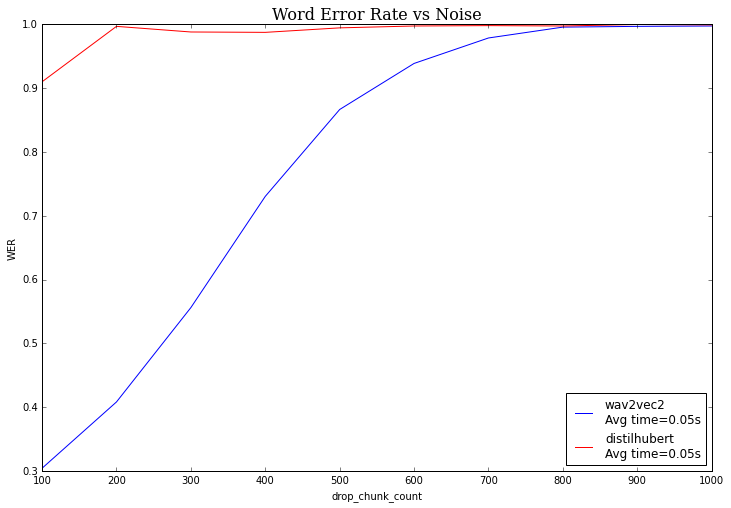

In [5]:
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
    
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

for noise_type in ["white_noise", "speed_perturb", "drop_chunk_length", "drop_chunk_count"]:
    print("Noise type:", noise_type)
    w2v_noises = []
    w2v_wers = []
    hubert_noises = []
    hubert_wers = []
    w2v_time = []
    hubert_time = []
    
    noise_list = []
    if noise_type == "white_noise":
        noise_list = np.arange(0, 1.1, .1)
    elif noise_type == "speed_perturb":
        noise_list = np.arange(50,250,25)
    elif noise_type == "drop_chunk_length":
        noise_list = np.arange(0,1100,100)
    elif noise_type == "drop_chunk_count":
        noise_list = np.arange(100,1100,100)
    else:
        assert(False)
        
    for model_type in ["wav2vec2", "hubert"]:
        print("Model_type:", model_type)
        for noise in noise_list:
            start_time = time.time()
            new_dset = dset.map(addnoise_noisy_decoding, 
                                fn_kwargs = {"noise": noise, "model_type": model_type, "noise_type" : noise_type}, 
                                batch_size = 1,
                                load_from_cache_file=False)
            tot_time = (time.time() - start_time) / len(dset)

            wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
            print("Model_type: {}, Noise: {}, Test WER: {:.3f}".format(model_type, noise, wer))
            if model_type == "wav2vec2":
                w2v_noises.append(noise)
                w2v_wers.append(wer)
                w2v_time.append(tot_time)
            else:
                hubert_noises.append(noise)
                hubert_wers.append(wer)
                hubert_time.append(tot_time)


    fig = plt.figure(figsize=(12, 8))
    w2vtime = np.round(np.mean(np.array(w2v_time)), 2)
    huberttime=np.round(np.mean(np.array(hubert_time)), 2)
    plt.plot(w2v_noises, w2v_wers, '-b', alpha=1, label='wav2vec2\nAvg time={}s'.format(w2vtime))
    plt.plot(hubert_noises, hubert_wers, '-r', alpha=1, label='distilhubert\nAvg time={}s'.format(huberttime))
    if noise_type[0] == 'd':
        plt.legend(loc = 'lower right')
    else:
        plt.legend(loc = 'upper left')
    plt.xlabel(noise_type)
    plt.ylabel("WER")
    plt.title("Word Error Rate vs Noise", fontsize=16, family='serif')
    plt.savefig('{}.pdf'.format(noise_type))
#     plt.show()